In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from scfw.frank_wolfe import frank_wolfe
from scfw.scopt import scopt
import scfw.phase_retrival as pr

## Data load

In [2]:
data_folder = '../data/'
problem_name = 'phase_data_15_100'
results = {problem_name: {}}
results_folder = './results/'
results_file = os.path.join(results_folder,'phase_retrival',problem_name+'.pckl')

In [3]:
# load data
with open(os.path.join(data_folder, problem_name + '.pckl'), 'rb') as f:
    data = pickle.load(f)
    
a = data['a']
x_sol = data['x_sol']
x_0 = data['x_0']
y = data['y']

for i in range(a.shape[0]):
    a[i,:]=a[i,:] / np.linalg.norm(a[i,:])
A = np.array([np.dot(a_i.reshape(-1, 1), np.conj(a_i).reshape(1, -1)) for a_i in a])
X_sol = np.dot(x_sol.reshape(-1, 1), np.conj(x_sol).reshape(1, -1))
X_0 = np.dot(x_0.reshape(-1, 1), np.conj(x_0).reshape(1, -1))

c = np.mean(y)
print(c, sum(np.diag(X_sol.real)))

40.51 19.825233152469856


## Parameters initialization

In [4]:
#first set of parameters
Mf = 2
nu = 3
#running parameters

terminate_tol = 1e-10

FW_params={
    'iter_FW': 50000,
    'line_search_tol': 1e-10,
}


sc_params={
    #parameters for SCOPT
    'iter_SC': 1000,
    'Lest': 'estimate', #estimate L
    'use_two_phase': True,
    #FISTA parameters
    'fista_type': 'mfista',
    'fista_tol': 1e-5,
    'fista_iter': 1000,
    #Conjugate Gradient Parameters
    'conj_grad_tol': 1e-2,
    'conj_grad_iter': 100,
}

# Auxilary functions

In [5]:
func_x = lambda X: pr.phase_val(A, X, y)
func_beta = lambda X, S, beta, extra_param, extra_param_s: pr.phase_val(A, (1 - beta) * X + beta * S, y)
grad_x = lambda X, trace_sum: pr.phase_gradient(A, X, y, trace_sum)
grad_beta = lambda X, S, beta, trace_sum, trace_sum_s: pr.phase_gradient(A, (1 - beta) * X + beta * S, y)
hess_mult_x = lambda S, trace_sum: pr.hess_mult(A, y, S, trace_sum)
hess_mult_vec_x = lambda S, trace_sum: pr.hess_mult_vec(A, y, S, trace_sum)
extra_func = lambda X: np.array([np.trace(A_i.dot(X)).real for A_i in A])
linear_oracle = lambda grad: pr.linear_oracle(grad, c)
prox_func = lambda X, L: pr.proj_map(X, c) #used for SCOPT

## Run FW

In [6]:
run_alpha_policies = ["standard", "line_search", "icml", "backtracking"]

for policy in run_alpha_policies:
    x, alpha_hist, Gap_hist, Q_hist, time_hist  = frank_wolfe(func_x,
                       func_beta,                                       
                       grad_x,
                       grad_beta,
                       hess_mult_x,
                       extra_func,                                                    
                       Mf,
                       nu,
                       linear_oracle,                                                    
                       X_0,
                       FW_params,
                       #hess=hess_x, 
                       #lloo_oracle=llo_oracle,                                                 
                       alpha_policy=policy,                                                    
                       eps=terminate_tol, 
                       print_every=1000, 
                       debug_info=False)
    
    results[problem_name][policy] = {
        'x': x,
        'alpha_hist': alpha_hist,
        'Gap_hist': Gap_hist,
        'Q_hist': Q_hist,
        'time_hist': time_hist,
    }

4444862270450046e-06, upper_bound=-6312.053215430313, lower_bound=-6312.077413771191, real_Gap=0.02419834087777417
iter = 41000, stepsize = 2.8374313842505217e-05, criterion = 6.4444862270450046e-06, upper_bound=-6312.053655614293, lower_bound=-6312.077413771191, real_Gap=0.023758156897201843
iter = 42000, stepsize = 5.077366949990392e-05, criterion = 5.945262552001415e-06, upper_bound=-6312.054078806468, lower_bound=-6312.077413771191, real_Gap=0.02333496472238039
iter = 43000, stepsize = 1.5187019016593695e-05, criterion = 5.945262552001415e-06, upper_bound=-6312.054482119268, lower_bound=-6312.076937037172, real_Gap=0.02245491790381493
iter = 44000, stepsize = 1.1097465176135302e-05, criterion = 5.529911284889988e-06, upper_bound=-6312.054862301126, lower_bound=-6312.076937037172, real_Gap=0.022074736045397003
iter = 45000, stepsize = 1.9127095583826303e-05, criterion = 5.529911284889988e-06, upper_bound=-6312.055232328943, lower_bound=-6312.076937037172, real_Gap=0.0217047082287535

## Run SCOPT

In [7]:
X, alpha_hist, Q_hist, time_hist = scopt(func_x,
          grad_x,
          hess_mult_x,
          hess_mult_vec_x,
          Mf,
          nu,
          prox_func,
          X_0,  
          sc_params,                                              
          eps=terminate_tol,                                              
          print_every=1)
    
results[problem_name]['scopt'] = {
    'x': X,
    'alpha_hist': alpha_hist,
    #'Gap_hist': Gap_hist,
    'Q_hist': Q_hist,
    'time_hist': time_hist,
}

iter =    1, stepsize = 2.274e-02, rdiff = 7.817e-02 , f = -1027.35

iter =    2, stepsize = 2.312e-02, rdiff = 7.532e-02 , f = -1078.18

iter =    3, stepsize = 2.353e-02, rdiff = 7.324e-02 , f = -1128.78

iter =    4, stepsize = 2.394e-02, rdiff = 7.129e-02 , f = -1179.18

iter =    5, stepsize = 2.432e-02, rdiff = 6.977e-02 , f = -1229.38

iter =    6, stepsize = 2.462e-02, rdiff = 6.851e-02 , f = -1279.35

Fista err = 9.920e-06; Subiter = 239; subproblem converged!

iter =    7, stepsize = 2.485e-02, rdiff = 6.671e-02 , f = -1329.06

iter =    8, stepsize = 2.589e-02, rdiff = 6.634e-02 , f = -1378.43

Fista err = 9.876e-06; Subiter = 218; subproblem converged!

iter =    9, stepsize = 2.600e-02, rdiff = 6.379e-02 , f = -1427.97

Fista err = 9.991e-06; Subiter = 196; subproblem converged!

iter =   10, stepsize = 2.580e-02, rdiff = 6.093e-02 , f = -1477.04

Fista err = 9.940e-06; Subiter = 195; subproblem converged!

iter =   11, stepsize = 2.681e-02, rdiff = 6.063e-02 , f = -1525.2

In [8]:
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

22.13160091502721
-1972.356857286907
-3735.5538870193523


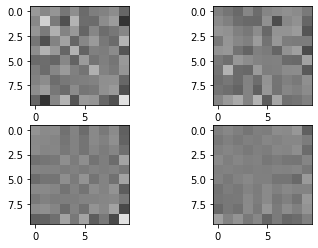

In [13]:
plt.subplot(2, 2, 1)
plt.imshow(X.real,cmap='gray',vmin=-10,vmax=10)
plt.subplot(2, 2, 2)
plt.imshow(X.imag,cmap='gray',vmin=-10,vmax=10)
plt.subplot(2, 2, 3)
plt.imshow(X_sol.real,cmap='gray',vmin=-10,vmax=10)
plt.subplot(2, 2, 4)
plt.imshow(X_sol.imag,cmap='gray',vmin=-10,vmax=10)
print(np.linalg.norm(X_sol-X))
print(func_x(X_sol)[0])
print(func_x(X)[0])